In [2]:
import scipy.io as sio 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
from reinforcement_learning_mp import offpolicy_eval_tdlearning_with_morta_mp
from utils import smooth 
from sklearn.cluster import KMeans
import pickle 
from multiprocessing import freeze_support 

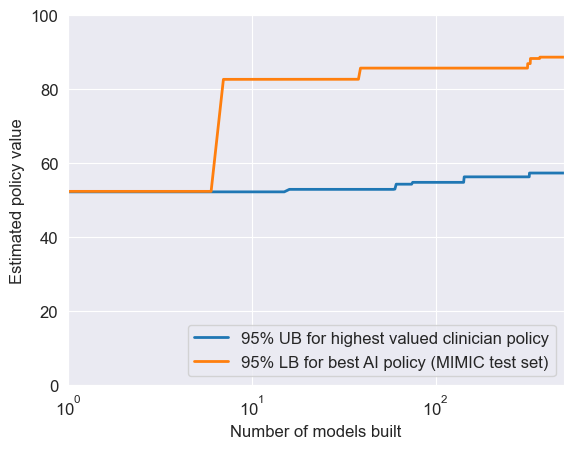

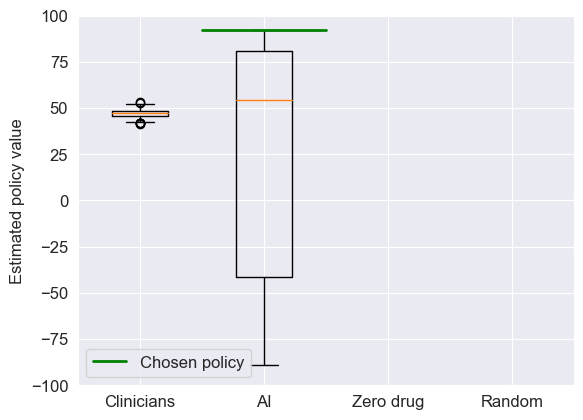

####   MODEL CALIBRATION - CLINICIANS POLICY EVALUATION WITH TD LEARNING   ####


/Users/adi/Documents/JHU/carey_Ra/py_ai_clinician/utils.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(v,y1)[0]


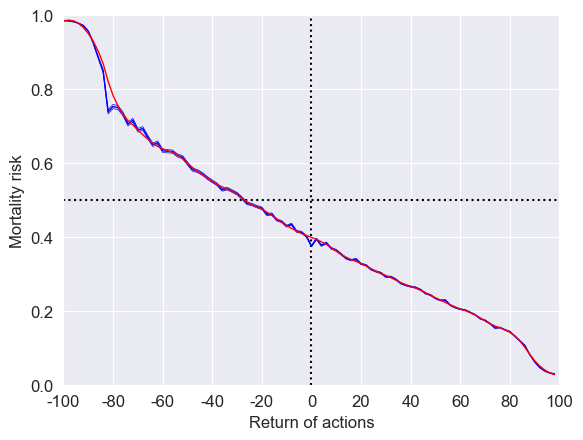

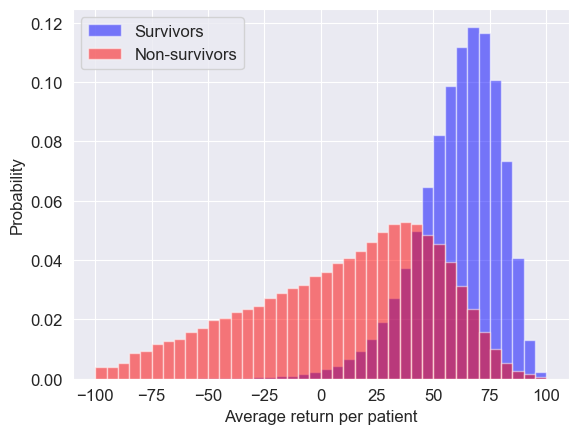

In [3]:
if __name__ == '__main__': 
    
    freeze_support()

    # Loading start file 

    with open('bestpol.pkl', 'rb') as file:
        modl = pickle.load(file)
        Qon = pickle.load(file)
        physpol = pickle.load(file)
        transitionr = pickle.load(file) 
        transitionr2 = pickle.load(file)
        R = pickle.load(file)
        C = pickle.load(file)
        train = pickle.load(file)
        qldata3train = pickle.load(file)
        qldata3test = pickle.load(file)

    with open('step_5_start.pkl','rb') as file: 
        MIMICzs = pickle.load(file)
        actionbloc = pickle.load(file)
        reformat5 = pickle.load(file)
        recqvi = pickle.load(file) 

    idx=C.predict(MIMICzs[train,:])  #N-D nearest point search: look for points closest to each centroid
    actionbloctrain=actionbloc[train==True]
    outcome = 9 #   HOSPITAL MORTALITY = 8 / 90d MORTA = 10
    Y90=reformat5[train==True,outcome]
    ptid=reformat5[train==True,1] 
    
    ## FIB 2A plot safety of algos: 95th UB of physicians policy value vs 95th LB of AI policy
    # during bulding of 500 different models
    # show that the value of AI policy is always guaranteed to be better than doctors' according to the model

    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots()
    plt.ylim(0,100)
    plt.xlim(1,500)

    r = recqvi 
    # print(r.shape[0])
    x = np.zeros((r.shape[0],1))
    m = np.zeros((r.shape[0],1)) 
    for i in range(r.shape[0]): 
        x[i] = i+1 # start from one 
        if(r[i,18]>max(m)): # physicians    // OR 19 = 95th percentile!!!!!!!!!!!!
            m[i]=r[i,18] 
        else: 
            m[i]=max(m) 


    ax.semilogx(x,m,linewidth=2)


    x = np.zeros((r.shape[0],1))    
    m = np.zeros((r.shape[0],1)) 

    for i in range(r.shape[0]): 
        x[i] = i+1 # start from one 
        if(r[i,23]>max(m)): # learnt policy
            m[i]=r[i,23] 
        else: 
            m[i]=max(m) 
    ax.semilogx(x,m,linewidth=2)

    ax.set_xlabel('Number of models built')
    ax.set_ylabel('Estimated policy value')
    ax.legend(['95% UB for highest valued clinician policy','95% LB for best AI policy (MIMIC test set)'],loc='lower right')
    plt.show() 

    # eICU part was not included 
    
    ## FIG 2B BOXPLOT OF POLICY VALUE OVER 500 MODELS -  MIMIC TEST SET ONLY

    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots()
    ax.boxplot(recqvi[:,[19, 21, 24, 25]],labels=['Clinicians','AI','Zero drug','Random']) # some evaluations not done here
    plt.xlim(0.5,4.5)
    plt.ylim(-100,100)
    ax.set_ylabel('Estimated policy value')

    # print([max(recqvi[:,21]),max(recqvi[:,21])])

    line = mlines.Line2D([1.5,2.5],[max(recqvi[:,21]),max(recqvi[:,21])],linewidth=2,color='green')
    ax.add_line(line)
    ax.legend([line],['Chosen policy'],loc='lower left')
    plt.show() 

    ## FIG 2C = MODEL CALIBRATION

    # TD learning of physicians / bootstrapped, in MIMIC train set.
    # This version also records action return and mortality, for the plot (nb: no parfor here)

    print('####   MODEL CALIBRATION - CLINICIANS POLICY EVALUATION WITH TD LEARNING   ####')
    bootql,prog=offpolicy_eval_tdlearning_with_morta_mp( qldata3train, physpol, ptid,  idx, actionbloctrain, Y90, 0.99, 100 ) # 100 reps

    nbins=100
    a=prog[:,0] #Q values of actual actions
    qv=np.floor((a+100)/(200/nbins))  # converts Q values to integers btw 0 and nbins
    m=prog[:,1]  #outcome
    h=np.zeros((nbins,5))  #avg mortality and other results, per bin

    for i in range(nbins):     
        ii=(qv==i) 
        h[i,0]=np.nanmean(m[ii])  # mean mortality in this bin
        if m[ii].size>0: 
            h[i,4]=np.nanmean(a[ii]) #record the mean of Q values in the bin (to make sure it matches what I expect)
        h[i,1]=np.std(m[ii])/np.sqrt(m[ii].size) # SEM of mortality in this bin
        h[i,2]=m[ii].size # nb of data points in this bin

    h[:,3]=h[:,0]*h[:,2]/qv.size # weighted average!!
    # [nansum(h(:,4)) mean(prog(:,2))] %check that both are close!

    yy1=smooth(np.array(range(nbins)),h[:,0],0.1)


    fig, ax = plt.subplots()
    plt.xlim(0,nbins)
    plt.ylim(0,1)
    plt.plot([0,nbins],[0.5,0.5],linestyle=':',color='black')
    plt.plot([nbins/2,nbins/2],[0,1],linestyle=':',color='black')
    plt.plot(h[:,0],linewidth=1,color='blue')
    plt.plot(h[:,0]+h[:,1],linewidth=0.5,color='blue')
    plt.plot(h[:,0]-h[:,1],linewidth=0.5,color='blue')
    plt.plot(yy1,linewidth=1,color='red')
    ax.set_ylabel('Mortality risk')
    ax.set_xlabel('Return of actions')
    plt.xticks(np.arange(0,nbins+10,step = nbins/10), np.arange(-100,120,step=20))
    plt.show() 
    
    ## FIG 2D = Computes avg Q value per patient / MIMIC TRAIN SET
    fig, ax = plt.subplots()
    df = pd.DataFrame(prog,columns = ['Qoff','morta','id','rep'])
    d = df.groupby(['rep','id']).mean()
    edges = np.arange(-100,105,5)
    data = np.array(d[d['morta']==0]['Qoff'])
    plt.hist(data,edges,facecolor='b',weights=np.ones(len(data)) / len(data), alpha=0.5)
    data = np.array(d[d['morta']==1]['Qoff'])
    plt.hist(data,edges,facecolor='r',weights=np.ones(len(data)) / len(data), alpha=0.5)
    ax.legend(['Survivors','Non-survivors'],loc='upper left')
    ax.set_xlabel('Average return per patient')
    ax.set_ylabel('Probability')
    plt.show()

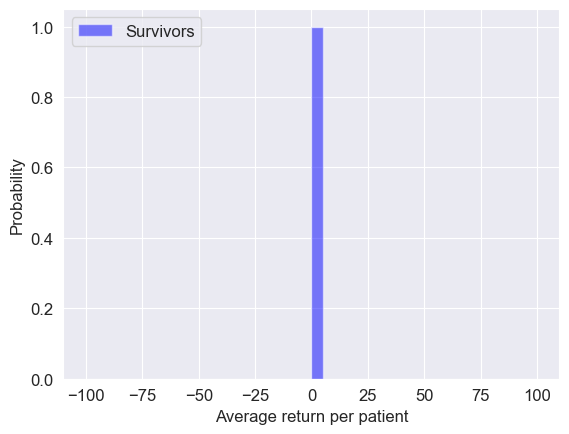

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'recqvi' has been loaded and contains the required summary statistics
# You need to extract the Q-values for the clinician's policy (column 19 in recqvi for mean Q-values)

# Create a DataFrame for the clinician's policy
# This is an example; modify it based on the exact structure of recqvi and qldata3train
df = pd.DataFrame(qldata3train, columns=['bloc', 'state', 'action', 'outcome', 'physpol', 'Qoff', 'OptimalAction', 'id'])

# Filter data based on the clinician's policy
df_clinician = df[df['physpol'] > 0]  # Adjust this condition based on actual data structure

# Calculate the mean Q-value per patient
d = df_clinician.groupby(['id']).mean()

# Define histogram edges
edges = np.arange(-100, 105, 5)

# Plot histogram for survivors (morta == 0)
data_survivors = np.array(d[d['outcome'] == 0]['Qoff'])
plt.hist(data_survivors, edges, facecolor='b', weights=np.ones(len(data_survivors)) / len(data_survivors), alpha=0.5)

# Plot histogram for non-survivors (morta == 1)
data_nonsurvivors = np.array(d[d['outcome'] == 1]['Qoff'])
# plt.hist(data_nonsurvivors, edges, facecolor='r', weights=np.ones(len(data_nonsurvivors)) / len(data_nonsurvivors), alpha=0.5)

# Add labels and legend
plt.legend(['Survivors', 'Non-survivors'], loc='upper left')
plt.xlabel('Average return per patient')
plt.ylabel('Probability')
plt.show()


In [52]:
print(ptid.min())
print(ptid.max())

3.0
99995.0


In [29]:
len(np.unique(df['id']))

16847

In [54]:
import pandas as pd

# Load the CSV file
df_demog = pd.read_csv('/Users/adi/mimic_sepsis/processed_files/demog1.csv', delimiter='|')

print("subject id:")
# Print the first few rows of the DataFrame
print(df_demog.iloc[0]['subject_id'])

print("icu stay id")
print(df_demog['icustay_id'].max())

subject id:
2.0
icu stay id
299999


In [68]:
import pandas as pd 
df_demog['gender'].max()

2

In [64]:
print(df_demog.iloc[0]['ethnicity'])
print(df_demog.iloc[0]["religion"])
print(df_demog.iloc[0]['insurance'])

1.0
1.0
0.0


In [70]:
import pandas as pd

# Load the CSV file
df_demog = pd.read_csv('/Users/adi/mimic_sepsis/processed_files/demog1.csv', delimiter='|')

# Print the first few rows of the DataFrame
print("subject id:")
print(df_demog.iloc[0]['subject_id'])

print("icu stay id")
print(df_demog['icustay_id'].max())
print(df_demog.iloc[0]['gender'])
print(df_demog.iloc[0]['ethnicity'])
print(df_demog.iloc[0]["religion"])
print(df_demog.iloc[0]['insurance'])

# Define and store icustay_id based on individual criteria
criteria_gender_1 = df_demog[df_demog['gender'] == 1]['icustay_id'].tolist()
criteria_gender_0 = df_demog[df_demog['gender'] == 2]['icustay_id'].tolist()

criteria_ethnicity_1 = df_demog[df_demog['ethnicity'] == 1]['icustay_id'].tolist()
criteria_ethnicity_0 = df_demog[df_demog['ethnicity'] == 0]['icustay_id'].tolist()

criteria_religion_1 = df_demog[df_demog['religion'] == 1]['icustay_id'].tolist()
criteria_religion_0 = df_demog[df_demog['religion'] == 0]['icustay_id'].tolist()

criteria_insurance_1 = df_demog[df_demog['insurance'] == 1]['icustay_id'].tolist()
criteria_insurance_0 = df_demog[df_demog['insurance'] == 0]['icustay_id'].tolist()

# Subtract 200000 from each element in the lists
criteria_gender_1 = [x - 200000 for x in criteria_gender_1]
criteria_gender_0 = [x - 200000 for x in criteria_gender_0]

criteria_ethnicity_1 = [x - 200000 for x in criteria_ethnicity_1]
criteria_ethnicity_0 = [x - 200000 for x in criteria_ethnicity_0]

criteria_religion_1 = [x - 200000 for x in criteria_religion_1]
criteria_religion_0 = [x - 200000 for x in criteria_religion_0]

criteria_insurance_1 = [x - 200000 for x in criteria_insurance_1]
criteria_insurance_0 = [x - 200000 for x in criteria_insurance_0]

# Print the lists and their lengths
print("ICU Stay IDs for gender == 1:")
print("Length:", len(criteria_gender_1))

print("ICU Stay IDs for gender == 2:")
print("Length:", len(criteria_gender_0))

print("ICU Stay IDs for ethnicity == 1:")
print("Length:", len(criteria_ethnicity_1))

print("ICU Stay IDs for ethnicity == 0:")
print("Length:", len(criteria_ethnicity_0))

print("ICU Stay IDs for religion == 1:")
print("Length:", len(criteria_religion_1))

print("ICU Stay IDs for religion == 0:")
print("Length:", len(criteria_religion_0))

print("ICU Stay IDs for insurance == 1:")
print("Length:", len(criteria_insurance_1))

print("ICU Stay IDs for insurance == 0:")
print("Length:", len(criteria_insurance_0))


subject id:
2.0
icu stay id
299999
1.0
1.0
1.0
0.0
ICU Stay IDs for gender == 1:
Length: 34469
ICU Stay IDs for gender == 2:
Length: 27063
ICU Stay IDs for ethnicity == 1:
Length: 18723
ICU Stay IDs for ethnicity == 0:
Length: 42809
ICU Stay IDs for religion == 1:
Length: 39939
ICU Stay IDs for religion == 0:
Length: 21593
ICU Stay IDs for insurance == 1:
Length: 37666
ICU Stay IDs for insurance == 0:
Length: 23866


In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

with open('bestpol.pkl', 'rb') as file:
    modl = pickle.load(file)
    Qon = pickle.load(file)
    physpol = pickle.load(file)
    transitionr = pickle.load(file) 
    transitionr2 = pickle.load(file)
    R = pickle.load(file)
    C = pickle.load(file)
    train = pickle.load(file)
    qldata3train = pickle.load(file)
    qldata3test = pickle.load(file)

with open('step_5_start.pkl','rb') as file: 
    MIMICzs = pickle.load(file)
    actionbloc = pickle.load(file)
    reformat5 = pickle.load(file)
    recqvi = pickle.load(file) 

idx=C.predict(MIMICzs[train,:])  #N-D nearest point search: look for points closest to each centroid
actionbloctrain=actionbloc[train==True]
outcome = 9 #   HOSPITAL MORTALITY = 8 / 90d MORTA = 10
Y90=reformat5[train==True,outcome]
ptid=reformat5[train==True,1] 

bootql,prog=offpolicy_eval_tdlearning_with_morta_mp( qldata3train, physpol, ptid,  idx, actionbloctrain, Y90, 0.99, 100 )
# Criteria dictionary for easier looping



# Assuming prog is already loaded and available as a DataFrame
df = pd.DataFrame(prog, columns=['Qoff', 'morta', 'id', 'rep'])
d = df.groupby(['rep', 'id']).mean()


In [128]:
# Function to plot histograms
def plot_histograms(criteria, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    edges = np.arange(-100, 105, 5)

    # Filter data
    data_survivors = np.array(d[(d.index.get_level_values('id').isin(criteria)) & (d['morta'] == 0)]['Qoff'])
    data_nonsurvivors = np.array(d[(d.index.get_level_values('id').isin(criteria)) & (d['morta'] == 1)]['Qoff'])
    
    print(f"Average Q return for Survivors : {np.mean(data_survivors)}:")
    print(f"Average Q return for Non - Survivors : {np.mean(data_nonsurvivors)}:")
    
    # Plot histograms
    ax.hist(data_survivors, edges, facecolor='b', weights=np.ones(len(data_survivors)) / len(data_survivors), alpha=0.5)
    ax.hist(data_nonsurvivors, edges, facecolor='r', weights=np.ones(len(data_nonsurvivors)) / len(data_nonsurvivors), alpha=0.5)

    # Customize plot
    ax.legend(['Survivors', 'Non-survivors'], loc='upper left')
    ax.set_xlabel('Average return per patient')
    ax.set_ylabel('Probability')
    ax.set_title(title)
    ax.grid(True)

    # Show plot
    plt.show()
    return data_survivors , data_nonsurvivors

Average Q return for Survivors : 61.52185584141035:
Average Q return for Non - Survivors : 9.368332830667047:


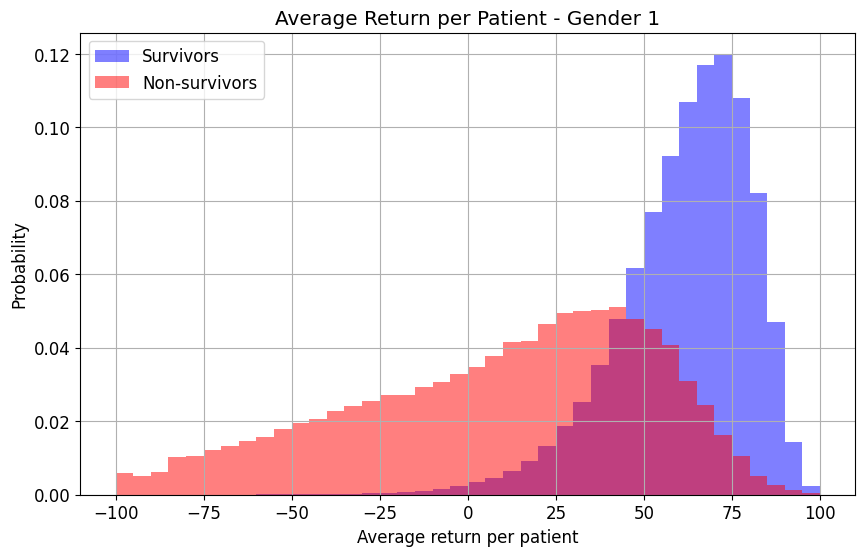

In [135]:
# Plot for criteria_gender_1
data_gender_survive_1 , data_gender_not_survive_1 =plot_histograms(criteria_gender_1, 'Average Return per Patient - Gender 1')

Average Q return for Survivors : 60.23308422935721:
Average Q return for Non - Survivors : 12.051592976237506:


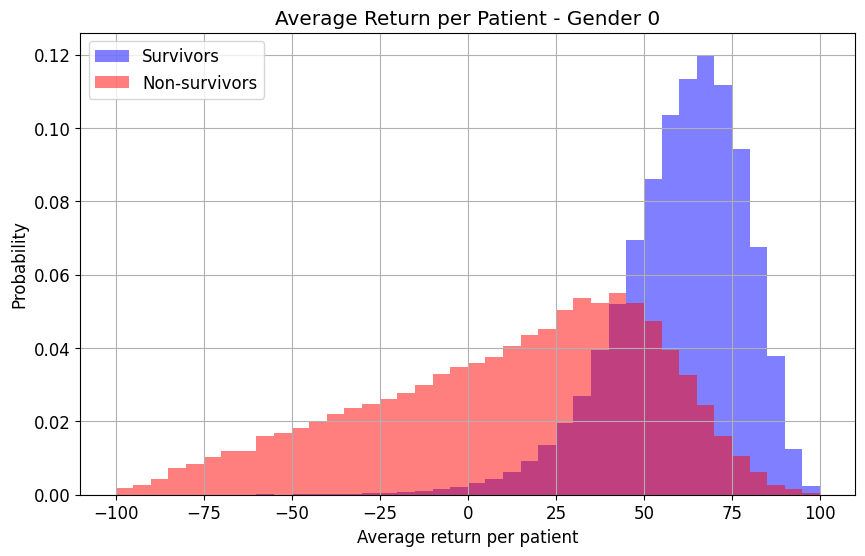

In [130]:
# Plot for criteria_gender_0
data_gender_survive_0 , data_gender_not_survive_0 = plot_histograms(criteria_gender_0, 'Average Return per Patient - Gender 0')

In [138]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


KS Statistic: 0.048301274637281066
P-value: 2.1966962143164316e-192


/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/2511593680.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_gender_survive_0, label='Survive Gender = 0', shade=True, color='blue', linewidth=2)
/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/2511593680.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_gender_survive_1, label='Survive Gender = 1', shade=True, color='red', linewidth=2)


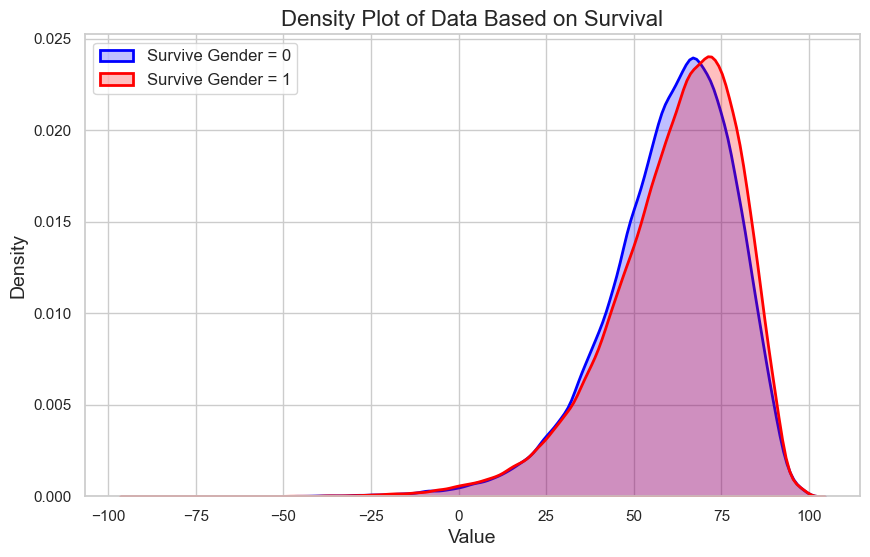

In [142]:
from scipy.stats import kstest
ks_stat, p_value = kstest(data_gender_survive_0 , data_gender_survive_1)
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data_gender_survive_0, label='Survive Gender = 0', shade=True, color='blue', linewidth=2)
sns.kdeplot(data_gender_survive_1, label='Survive Gender = 1', shade=True, color='red', linewidth=2)

# Adding title and labels
plt.title('Density Plot of Data Based on Survival', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Move the legend to the left
plt.legend(loc='upper left', fontsize=12)

# Show plot
plt.show()


KS Statistic: 0.026071360451507403
P-value: 2.4706435507314405e-17


/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/3433589369.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_gender_not_survive_0, label='Not Survive Gender= 0', shade=True, color='blue', linewidth=2)
/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/3433589369.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_gender_not_survive_1, label='Not Survive Gender = 1', shade=True, color='red', linewidth=2)


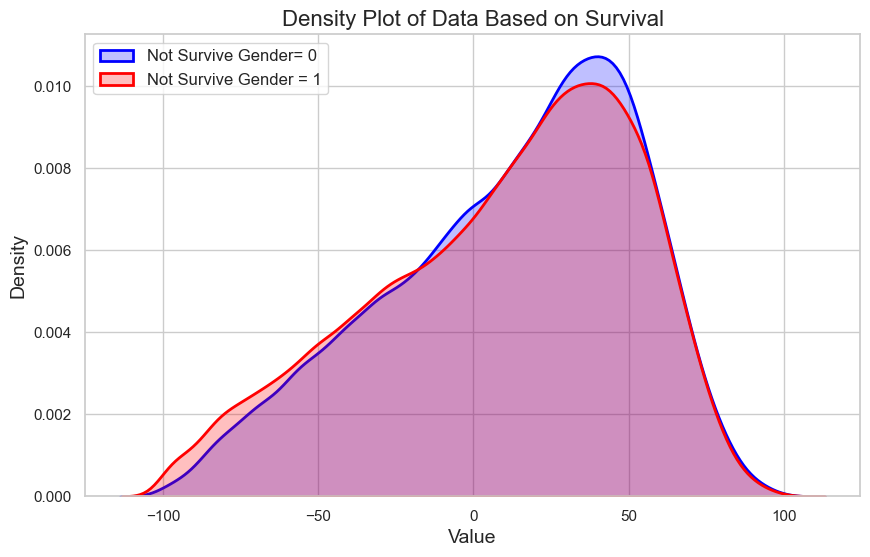

In [143]:
from scipy.stats import kstest
ks_stat, p_value = kstest(data_gender_not_survive_0 , data_gender_not_survive_1)
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data_gender_not_survive_0, label='Not Survive Gender= 0', shade=True, color='blue', linewidth=2)
sns.kdeplot(data_gender_not_survive_1, label='Not Survive Gender = 1', shade=True, color='red', linewidth=2)

# Adding title and labels
plt.title('Density Plot of Data Based on Survival', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Move the legend to the left
plt.legend(loc='upper left', fontsize=12)

# Show plot
plt.show()

Average Q return for Survivors : 61.19154758759504:
Average Q return for Non - Survivors : 4.852308356557637:


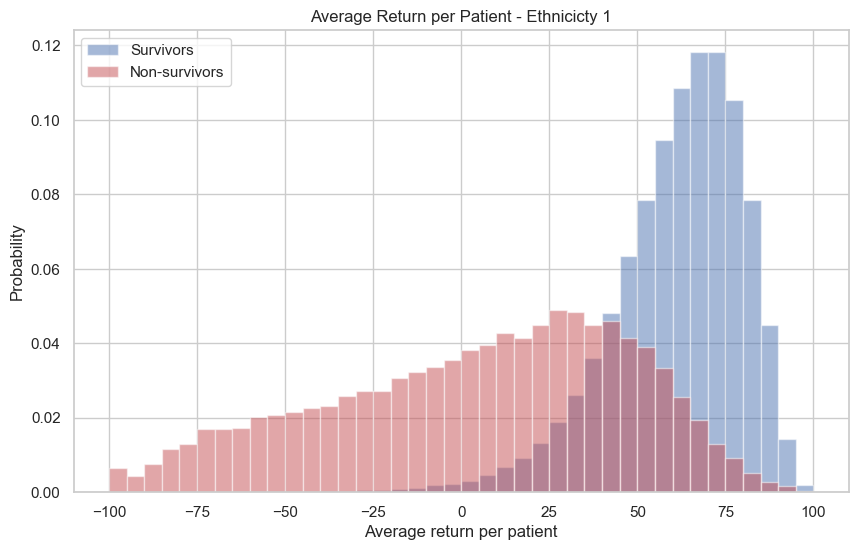

In [144]:
# Plot for criteria_gender_1
survive_e1 , n_survive_e1 = plot_histograms(criteria_ethnicity_1, 'Average Return per Patient - Ethnicicty 1')


Average Q return for Survivors : 60.85150096730867:
Average Q return for Non - Survivors : 12.573064518681031:


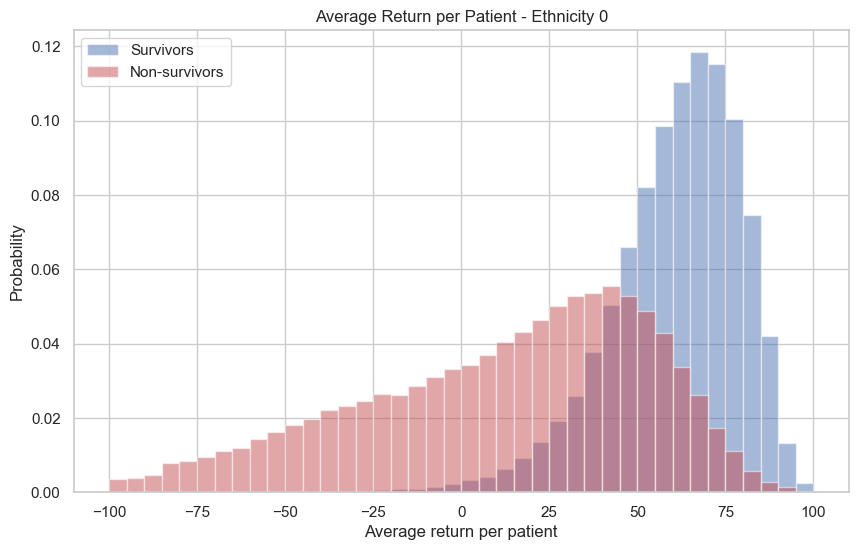

In [145]:
# Plot for criteria_gender_0
survive_e0 , n_survive_e0 =plot_histograms(criteria_ethnicity_0, 'Average Return per Patient - Ethnicity 0')

KS Statistic: 0.014860155956068266
P-value: 4.2566463269184254e-15


/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/3825167826.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(survive_e0, label='Survive Ethnicity= 0', shade=True, color='blue', linewidth=2)
/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/3825167826.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(survive_e1, label='Survive Ethnicity = 1', shade=True, color='red', linewidth=2)


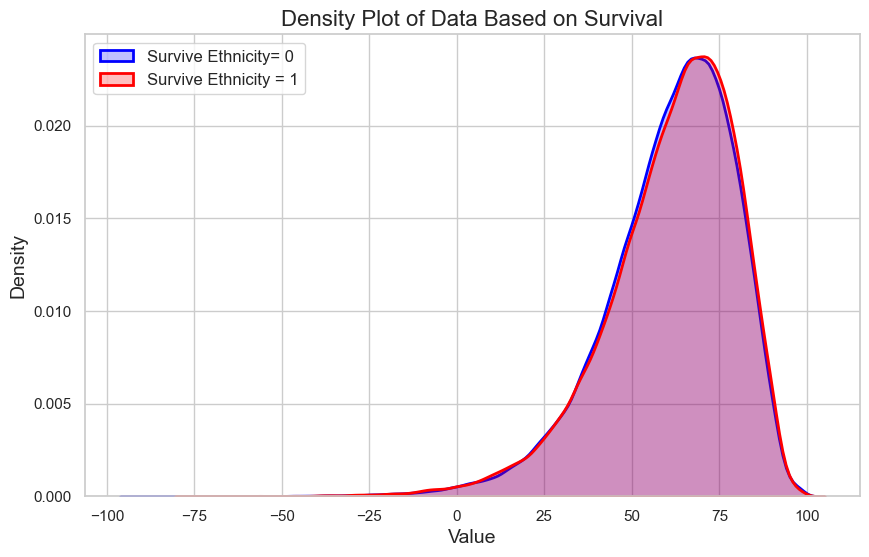

In [148]:
from scipy.stats import kstest
ks_stat, p_value = kstest( survive_e0 , survive_e1)
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(survive_e0, label='Survive Ethnicity= 0', shade=True, color='blue', linewidth=2)
sns.kdeplot(survive_e1, label='Survive Ethnicity = 1', shade=True, color='red', linewidth=2)

# Adding title and labels
plt.title('Density Plot of Data Based on Survival', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Move the legend to the left
plt.legend(loc='upper left', fontsize=12)

# Show plot
plt.show()

KS Statistic: 0.07952288436068744
P-value: 5.6072913345036255e-127


/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/2224091131.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_survive_e0, label='Not Survive Ethnicity= 0', shade=True, color='blue', linewidth=2)
/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/2224091131.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_survive_e1, label='Not Survive Ethnicity = 1', shade=True, color='red', linewidth=2)


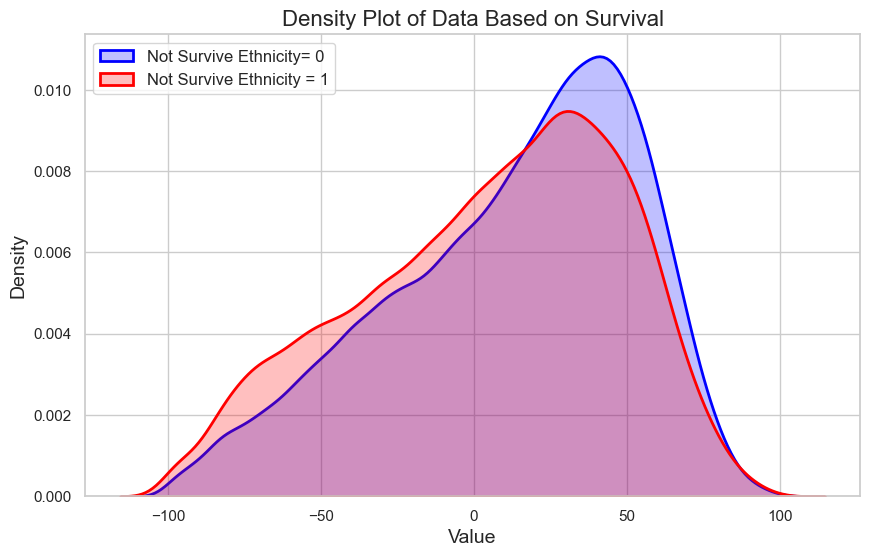

In [150]:
from scipy.stats import kstest
ks_stat, p_value = kstest( n_survive_e0 , n_survive_e1)
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(n_survive_e0, label='Not Survive Ethnicity= 0', shade=True, color='blue', linewidth=2)
sns.kdeplot(n_survive_e1, label='Not Survive Ethnicity = 1', shade=True, color='red', linewidth=2)

# Adding title and labels
plt.title('Density Plot of Data Based on Survival', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Move the legend to the left
plt.legend(loc='upper left', fontsize=12)

# Show plot
plt.show()

Average Q return for Survivors : 60.82663017059756:
Average Q return for Non - Survivors : 10.563017577124217:


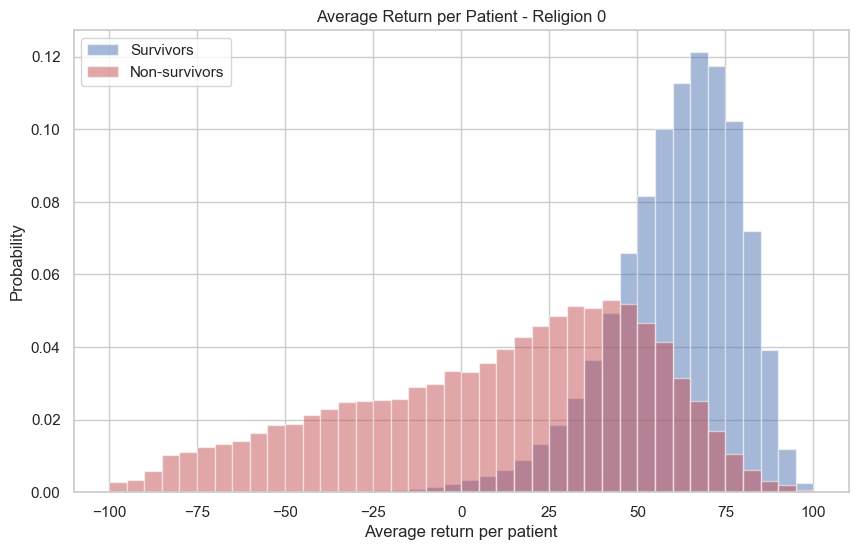

In [155]:
survive_r0 , n_survive_r0= plot_histograms(criteria_religion_0, 'Average Return per Patient - Religion 0')

Average Q return for Survivors : 61.018732266324335:
Average Q return for Non - Survivors : 10.46892734514435:


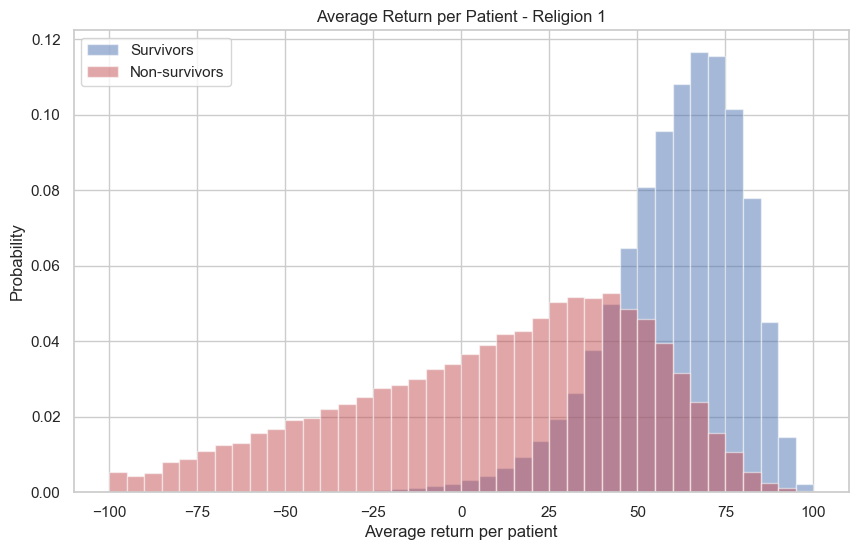

In [156]:
survive_r1 , n_survive_r1 = plot_histograms(criteria_religion_1, 'Average Return per Patient - Religion 1')

KS Statistic: 0.012585684638810157
P-value: 0.00034010205659863697


/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/3357368139.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_survive_r0, label='Not Survive Religion= 0', shade=True, color='blue', linewidth=2)
/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/3357368139.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_survive_r1, label='Not Survive Religion = 1', shade=True, color='red', linewidth=2)


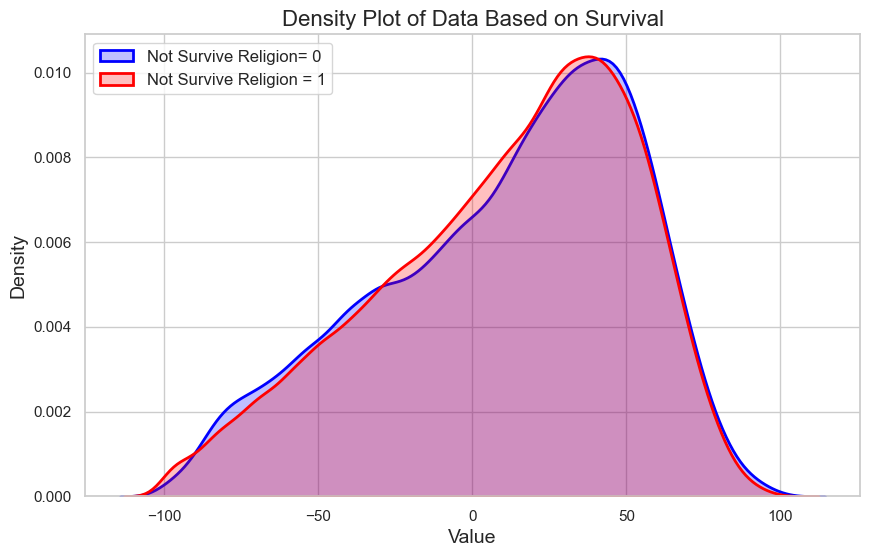

In [157]:
from scipy.stats import kstest
ks_stat, p_value = kstest( n_survive_r0 , n_survive_r1)
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(n_survive_r0, label='Not Survive Religion= 0', shade=True, color='blue', linewidth=2)
sns.kdeplot(n_survive_r1, label='Not Survive Religion = 1', shade=True, color='red', linewidth=2)

# Adding title and labels
plt.title('Density Plot of Data Based on Survival', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Move the legend to the left
plt.legend(loc='upper left', fontsize=12)

# Show plot
plt.show()

KS Statistic: 0.015237782986290194
P-value: 1.1354910355291645e-18


/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/2361184507.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(survive_r0, label=' Survive Religion= 0', shade=True, color='blue', linewidth=2)
/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/2361184507.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(survive_r1, label=' Survive Religion = 1', shade=True, color='red', linewidth=2)


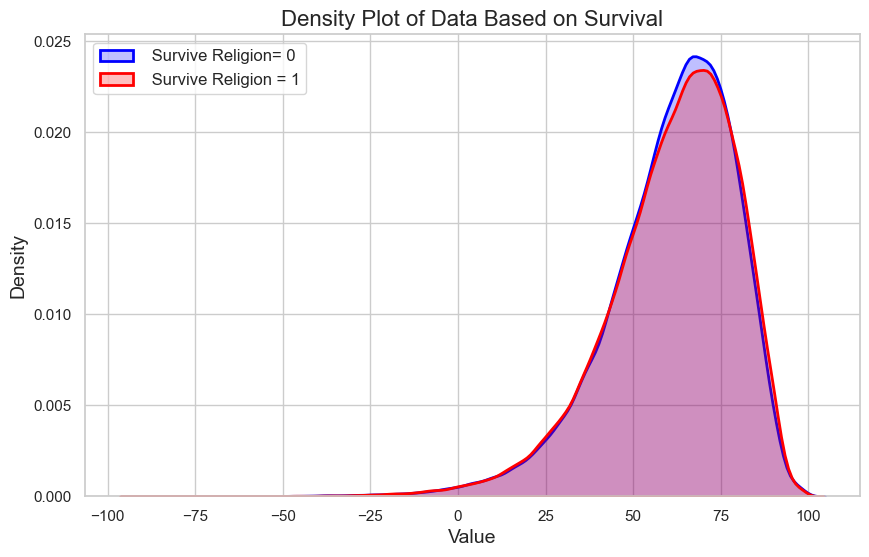

In [158]:
from scipy.stats import kstest
ks_stat, p_value = kstest( survive_r0 , survive_r1)
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(survive_r0, label=' Survive Religion= 0', shade=True, color='blue', linewidth=2)
sns.kdeplot(survive_r1, label=' Survive Religion = 1', shade=True, color='red', linewidth=2)

# Adding title and labels
plt.title('Density Plot of Data Based on Survival', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Move the legend to the left
plt.legend(loc='upper left', fontsize=12)

# Show plot
plt.show()

Average Q return for Survivors : 64.29495883338656:
Average Q return for Non - Survivors : 8.070349532532129:


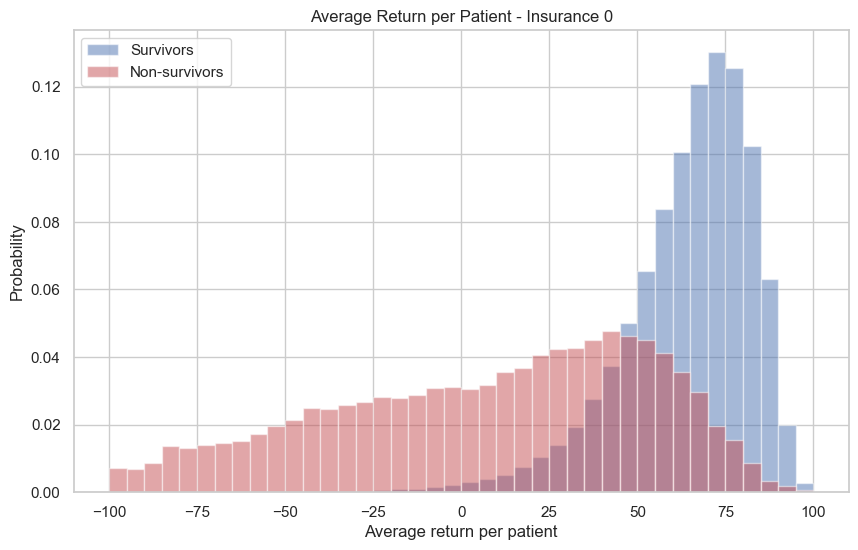

In [159]:
survive_i0 , n_survive_i0 = plot_histograms(criteria_insurance_0, 'Average Return per Patient - Insurance 0')

Average Q return for Survivors : 59.37027796515911:
Average Q return for Non - Survivors : 11.229433312105236:


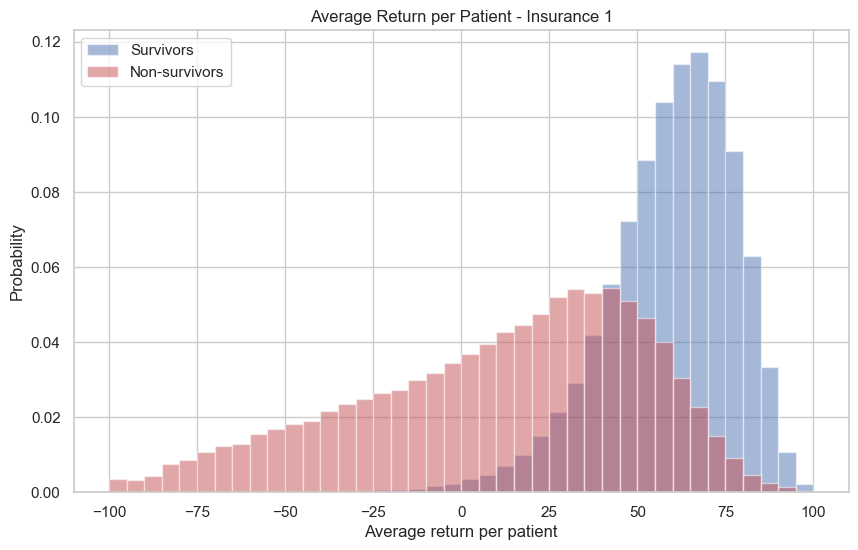

In [160]:
survive_i1 , n_survive_i1 = plot_histograms(criteria_insurance_1, 'Average Return per Patient - Insurance 1')

KS Statistic: 0.05365850711873163
P-value: 2.3425939425919726e-52


/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/3917379421.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_survive_i0, label='Not Survive Insurance= 0', shade=True, color='blue', linewidth=2)
/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/3917379421.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_survive_i1, label='Not Survive Insurance = 1', shade=True, color='red', linewidth=2)


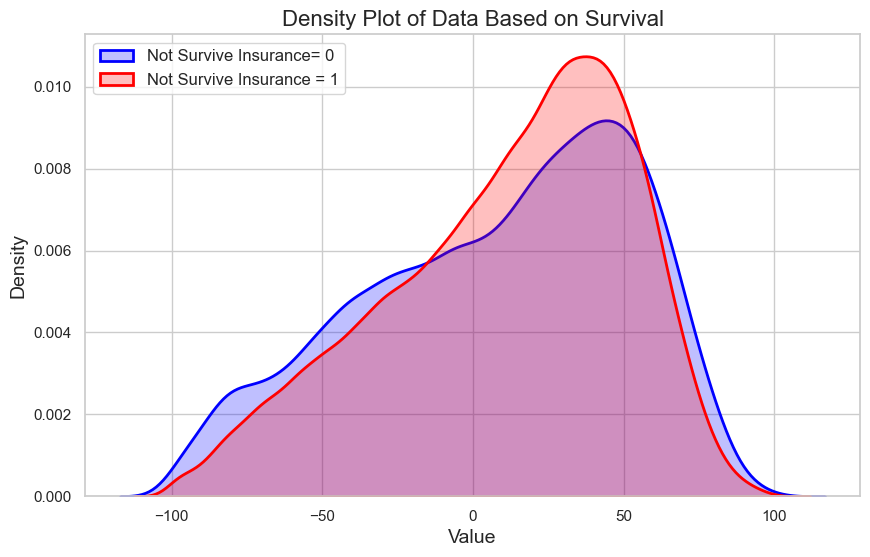

In [161]:
from scipy.stats import kstest
ks_stat, p_value = kstest( n_survive_i0 , n_survive_i1)
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(n_survive_i0, label='Not Survive Insurance= 0', shade=True, color='blue', linewidth=2)
sns.kdeplot(n_survive_i1, label='Not Survive Insurance = 1', shade=True, color='red', linewidth=2)

# Adding title and labels
plt.title('Density Plot of Data Based on Survival', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Move the legend to the left
plt.legend(loc='upper left', fontsize=12)

# Show plot
plt.show()

KS Statistic: 0.13948712102648642
P-value: 0.0


/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/658172267.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(survive_i0, label=' Survive Insurance= 0', shade=True, color='blue', linewidth=2)
/var/folders/wf/bdvgbxcj761970v614srxl9m0000gn/T/ipykernel_55705/658172267.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(survive_i1, label=' Survive Insurance = 1', shade=True, color='red', linewidth=2)


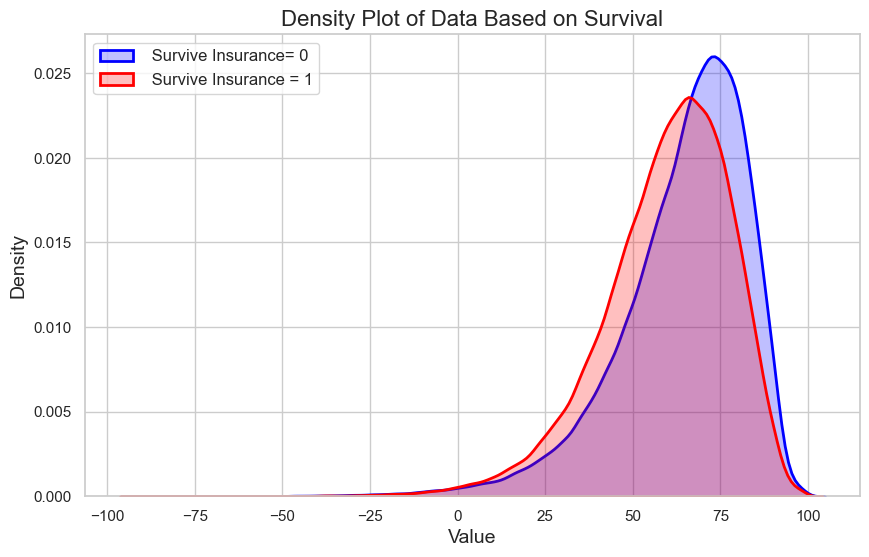

In [162]:
from scipy.stats import kstest
ks_stat, p_value = kstest( survive_i0 , survive_i1)
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(survive_i0, label=' Survive Insurance= 0', shade=True, color='blue', linewidth=2)
sns.kdeplot(survive_i1, label=' Survive Insurance = 1', shade=True, color='red', linewidth=2)

# Adding title and labels
plt.title('Density Plot of Data Based on Survival', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Move the legend to the left
plt.legend(loc='upper left', fontsize=12)

# Show plot
plt.show()